In [150]:
import pandas as pd
import researchpy as rp


import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
df = pd.read_csv('upload_bce_harmonic_ANOVA.txt', header=0, sep="\t")
df.drop('metric',axis=1,inplace=True)

In [128]:
df.head()

,embeddings,projections,lambda_c,negative_count,map_mrr
0,ft,1,0.0,1,0.4277
1,ft,1,0.0,5,0.4313
2,ft,1,0.0,10,0.4301
3,ft,1,0.1,1,0.4164
4,ft,1,0.1,5,0.4149


In [20]:
# filter out yamane results
df = df.loc[df.method == 'multi',]
df.drop('method', axis=1, inplace=True)

In [22]:
# unpivot data
#df = pd.melt(df.reset_index(), id_vars=['embeddings', 'model','clusters', 'metric'], value_vars=['fold_1','fold_2','fold_3','fold_4','fold_5'])
df = pd.melt(df.reset_index(), id_vars=['embeddings', 'projections','lambda_c','negative_count'], value_vars=['hm_fold1','hm_fold2','hm_fold3','hm_fold4','hm_fold5'])

In [24]:
# drop metric and variable columns since they're not useful

df.drop('variable',axis=1,inplace=True)

# rename value to actual metric (our dependent variable)
df.rename(columns={'value':'map_mrr'}, inplace=True)

In [37]:
# separate the embeddings
w2v = df.loc[df['embeddings']=='w2v', :]
ft = df.loc[df['embeddings']=='ft', :]
glove = df.loc[df['embeddings']=='glove', :]


In [26]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov



In [29]:
def print_model(mod):
    print(f"Overall model F({mod.df_model: .0f},{mod.df_resid: .0f}) = {mod.fvalue: .3f}, p = {mod.f_pvalue: .10f}")

In [38]:
# Statistical evidence  of multicollinearity found when attempting to run 3-way ANOVA explaining the interaction
# of projections, lambda_c and negative_count.  From our results, we observed that regularisation impace
# looked small.  We will eliminate this factor and performa 2-way ANOVA, which also reduces the complexity
# of the exercise as a welcome side-effect.
w2v = w2v.loc[w2v.lambda_c==0,]

w2v.count()

embeddings        45
projections       45
lambda_c          45
negative_count    45
map_mrr           45
dtype: int64

# Evaluate w2v results

In [39]:


# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
w2v_model = ols('map_mrr ~ C(projections)*C(negative_count)', w2v).fit()

# Seeing if the overall model is significant
print_model(w2v_model)

# the interaction model is significant, F(8, 36) = 11.23, p<< 0.05

Overall model F( 8, 36) =  11.230, p =  0.0000000850


In [40]:
w2v_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     11.23
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           8.50e-08
Time:                        22:57:07   Log-Likelihood:                 136.31
No. Observations:                  45   AIC:                            -254.6
Df Residuals:                      36   BIC:                            -238.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.3748      0.006     64.060      0.000       0.363       0.387
C(projections)[T.5]                             -0.0346      0.008     -4.180      0.000      -0.051      -0.018
C(projections)[T.10]                            -0.0519      0.008     -6.276      0.000      -0.069      -0.035
C(negative_count)[T.5]                           0.0060      0.008      0.728      0.472      -0.011       0.023
C(negative_count)[T.10]                          0.0092      0.008      1.110      0.275      -0.008       0.026
C(projections)[T.5]:C(negative_count)[T.5]       0.0162      0.012      1.385      0.175      -0.008       0.040
C(projections)[T.10]:C(negative_count)[T.5]      0.0287      0.012      2.455      0.019       0.005       0.052
C(projections)[T.5]:C(negative_count)[T.10]      0.0178      0.012      1.520      0.137      -0.006       0.042
C(projections)[T.10]:C(negative_count)[T.10]     0.0237      0.012      2.022      0.051   -6.91e-05       0.047
==============================================================================
Omnibus:                        2.736   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.040
Skew:                          -0.518   Prob(JB):                        0.361
Kurtosis:                       3.117   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Creates the ANOVA table
res = sm.stats.anova_lm(w2v_model, typ= 1)
anova_table(res)
# the projection count and negative sample count interaction term was not significant.  
# we re-run the model, this time investigating the effect of oprojections and negative_Cont independently

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.009269,0.004634,2.0,27.083575,6.646222e-08,0.430448,0.411286
C(negative_count),0.004867,0.002434,2.0,14.221349,2.807489e-05,0.226024,0.208474
C(projections):C(negative_count),0.001237,0.000309,4.0,1.807324,1.487992e-01,0.057449,0.025460
Residual,0.006160,0.000171,36.0,NaN,NaN,NaN,NaN


In [43]:
# we remove the interaction term and analyse the indepedent variables separately

w2v_model2 = ols('map_mrr ~ C(projections)+ C(negative_count)', w2v).fit()
print_model(w2v_model2)


Overall model F( 4, 40) =  19.110, p =  0.0000000074


In [44]:
w2v_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     19.11
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           7.40e-09
Time:                        23:01:50   Log-Likelihood:                 132.20
No. Observations:                  45   AIC:                            -254.4
Df Residuals:                      40   BIC:                            -245.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3652      0.005     80.557      0.000       0.356       0.374
C(projections)[T.5]        -0.0233      0.005     -4.683      0.000      -0.033      -0.013
C(projections)[T.10]       -0.0345      0.005     -6.940      0.000      -0.044      -0.024
C(negative_count)[T.5]      0.0210      0.005      4.228      0.000       0.011       0.031
C(negative_count)[T.10]     0.0230      0.005      4.630      0.000       0.013       0.033
==============================================================================
Omnibus:                        1.361   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                1.286
Skew:                          -0.287   Prob(JB):                        0.526
Kurtosis:                       2.403   Cond. No.                         4.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
res2 = sm.stats.anova_lm(w2v_model2, typ= 1)
anova_table(res2)

# Both factors were found to have a mild to medium effect.  
# Negative count had an effect on map_mrr, F(2,40)=13.159, p < 0.05 omega^2 = 0.21
# Projection influenced map_mrr at F(2,40) =25.06, p < 0.05, omega^2=0.41

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.009269,0.004634,2.0,25.060390,8.804424e-08,0.430448,0.409752
C(negative_count),0.004867,0.002434,2.0,13.158992,4.060443e-05,0.226024,0.207069
Residual,0.007397,0.000185,40.0,NaN,NaN,NaN,NaN


In [46]:
# employ Tukey's HSD to find evidence of effect in model
mc = statsmodels.stats.multicomp.MultiComparison(w2v['map_mrr'], w2v['negative_count'])
mc_results = mc.tukeyhsd()
print(mc_results)

# It is justifiable to increase negative count from 1 to 5 or from 1 to 10, both of which are expected to
# increase map_mrr.  Performance does not increase significantly when the negative count is augmented to 10 from 5.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      5     0.021    0.0033 0.0387  True 
  1      10    0.023    0.0053 0.0407  True 
  5      10    0.002   -0.0157 0.0197 False 
--------------------------------------------


In [47]:
mc = statsmodels.stats.multicomp.MultiComparison(w2v['map_mrr'], w2v['projections'])
mc_results = mc.tukeyhsd()
print(mc_results)

# larger number of projection have a detrimental effect on map_mrr.  Increasing projections from 1 to 10,
# will reduce the mean difference by 0.035 points.  A lower, but still significant effect is observed with 
# 5 projections.

# RUNS COUNTER TO CRIM, who found that increasing projections helped their results. 
# Their setup, however was not equivalent.  They trained embeddings alongside the rest of the model; 
# learning rate was significantly smaller; dropout rate was different and the number of training epochs
# much larger.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      5    -0.0233  -0.0384 -0.0081  True 
  1      10   -0.0345  -0.0496 -0.0193  True 
  5      10   -0.0112  -0.0264  0.004  False 
---------------------------------------------


# Evaluate GloVe

In [50]:
# filter out regularisation attempts
glove = glove.loc[glove.lambda_c==0,]

glove.count()

embeddings        45
projections       45
lambda_c          45
negative_count    45
map_mrr           45
dtype: int64

In [52]:
glove_model = ols('map_mrr ~ C(projections)*C(negative_count)', glove).fit()

# Seeing if the overall model is significant
print_model(glove_model)


Overall model F( 8, 36) =  17.774, p =  0.0000000002


In [53]:
glove_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     17.77
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           2.21e-10
Time:                        23:20:48   Log-Likelihood:                 143.16
No. Observations:                  45   AIC:                            -268.3
Df Residuals:                      36   BIC:                            -252.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.3062      0.005     60.943      0.000       0.296       0.316
C(projections)[T.5]                              0.0290      0.007      4.075      0.000       0.015       0.043
C(projections)[T.10]                             0.0422      0.007      5.941      0.000       0.028       0.057
C(negative_count)[T.5]                           0.0050      0.007      0.701      0.488      -0.009       0.019
C(negative_count)[T.10]                          0.0023      0.007      0.324      0.748      -0.012       0.017
C(projections)[T.5]:C(negative_count)[T.5]       0.0133      0.010      1.319      0.195      -0.007       0.034
C(projections)[T.10]:C(negative_count)[T.5]      0.0056      0.010      0.555      0.582      -0.015       0.026
C(projections)[T.5]:C(negative_count)[T.10]      0.0142      0.010      1.413      0.166      -0.006       0.035
C(projections)[T.10]:C(negative_count)[T.10]    -0.0047      0.010     -0.466      0.644      -0.025       0.016
==============================================================================
Omnibus:                        1.243   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.482
Skew:                          -0.117   Prob(JB):                        0.786
Kurtosis:                       3.450   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Creates the ANOVA table
res = sm.stats.anova_lm(glove_model, typ= 1)
anova_table(res)
# the projection count and negative sample count interaction term was not significant.  
# we re-run the model, this time investigating the effect of oprojections and negative_Cont independently

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.016400,0.008200,2.0,64.956633,1.136541e-12,0.729072,0.713842
C(negative_count),0.000951,0.000476,2.0,3.767302,3.269056e-02,0.042284,0.030887
C(projections):C(negative_count),0.000599,0.000150,4.0,1.185520,3.336857e-01,0.026613,0.004141
Residual,0.004545,0.000126,36.0,NaN,NaN,NaN,NaN


In [55]:
glove_model2 = ols('map_mrr ~ C(projections) + C(negative_count)', glove).fit()

print_model(glove_model2)

Overall model F( 4, 40) =  33.736, p =  0.0000000000


In [56]:
res2 = sm.stats.anova_lm(glove_model2, typ= 1)
anova_table(res2)

# The projection factor had a strong effect on map_mrr, F(2, 40) = 63.77, p << 0.05, omega^2 =0.714
# However, the negative count had a very weak, although sitll significant effect, F(2, 40) = 3.70, p< 0.05,
# omeg^2 = 0.031

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.016400,0.008200,2.0,63.773506,3.617979e-13,0.729072,0.713561
C(negative_count),0.000951,0.000476,2.0,3.698684,3.358268e-02,0.042284,0.030677
Residual,0.005143,0.000129,40.0,NaN,NaN,NaN,NaN


In [57]:
mc = statsmodels.stats.multicomp.MultiComparison(glove['map_mrr'], glove['projections'])
mc_results = mc.tukeyhsd()
print(mc_results)

# Increasing projections from 1 to 5 or 10 had a positive effect on map_mrr, 
# but a negligible effect when increasing projections from 5 to 10.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      5     0.0381   0.0274 0.0488  True 
  1      10    0.0425   0.0318 0.0532  True 
  5      10    0.0044  -0.0063 0.0151 False 
--------------------------------------------


In [58]:
mc = statsmodels.stats.multicomp.MultiComparison(glove['map_mrr'], glove['negative_count'])
mc_results = mc.tukeyhsd()
print(mc_results)

# post-hoc analysis revealed that increasing the negative count had no effect on the map_mrr.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      5     0.0113  -0.0088 0.0314 False 
  1      10    0.0055  -0.0146 0.0256 False 
  5      10   -0.0058  -0.0259 0.0143 False 
--------------------------------------------


# Evaluate fastText results

In [62]:
ft = ft.loc[ft.lambda_c==0,]

ft.count()

embeddings        45
projections       45
lambda_c          45
negative_count    45
map_mrr           45
dtype: int64

In [64]:
ft_model = ols('map_mrr ~ C(projections)*C(negative_count)', ft).fit()

# Seeing if the overall model is significant
print_model(ft_model)

# the overall model for the  interaction of projection and negative_count was viable, F(8, 36) = 8.217, p<0.05

Overall model F( 8, 36) =  8.217, p =  0.0000029644


In [65]:
ft_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     8.217
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           2.96e-06
Time:                        23:32:12   Log-Likelihood:                 170.15
No. Observations:                  45   AIC:                            -322.3
Df Residuals:                      36   BIC:                            -306.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.4276      0.003    155.042      0.000       0.422       0.433
C(projections)[T.5]                              0.0028      0.004      0.723      0.474      -0.005       0.011
C(projections)[T.10]                             0.0061      0.004      1.559      0.128      -0.002       0.014
C(negative_count)[T.5]                           0.0027      0.004      0.682      0.500      -0.005       0.011
C(negative_count)[T.10]                          0.0029      0.004      0.743      0.462      -0.005       0.011
C(projections)[T.5]:C(negative_count)[T.5]       0.0050      0.006      0.910      0.369      -0.006       0.016
C(projections)[T.10]:C(negative_count)[T.5]      0.0085      0.006      1.541      0.132      -0.003       0.020
C(projections)[T.5]:C(negative_count)[T.10]      0.0108      0.006      1.961      0.058      -0.000       0.022
C(projections)[T.10]:C(negative_count)[T.10]     0.0130      0.006      2.353      0.024       0.002       0.024
==============================================================================
Omnibus:                        1.389   Durbin-Watson:                   1.048
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.582
Skew:                          -0.014   Prob(JB):                        0.748
Kurtosis:                       3.556   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
# Creates the ANOVA table
res = sm.stats.anova_lm(ft_model, typ= 1)
anova_table(res)

# But upon inspecting the ANOVA table, we found the interaction term itself not to be significant.
# we fit a fresh model, that examines the independent effect of projections and negative_Count

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.001337,0.000668,2.0,17.569438,0.000005,0.345405,0.322574
C(negative_count),0.000911,0.000455,2.0,11.972467,0.000103,0.235372,0.213612
C(projections):C(negative_count),0.000253,0.000063,4.0,1.662168,0.180146,0.065354,0.025782
Residual,0.001369,0.000038,36.0,NaN,NaN,NaN,NaN


In [68]:
ft_model2 = ols('map_mrr ~ C(projections) + C(negative_count)', ft).fit()
print_model(ft_model2)

res2 = sm.stats.anova_lm(ft_model2, typ= 1)
anova_table(res2)

# The negative count, and projection factos both had a significant independent effect on map_mrr.
# Negative count is significant, F(2, 40) = 11.23, p < 0.05, omega^2 = 0.212
# projections are significant, F(2, 40) = 16.48, p < 0.05, omegae^2 = 0.321


Overall model F( 4, 40) =  13.854, p =  0.0000003547


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.001337,0.000668,2.0,16.478297,0.000006,0.345405,0.321078
C(negative_count),0.000911,0.000455,2.0,11.228923,0.000135,0.235372,0.212187
Residual,0.001622,0.000041,40.0,NaN,NaN,NaN,NaN


In [69]:
mc = statsmodels.stats.multicomp.MultiComparison(ft['map_mrr'], ft['projections'])
mc_results = mc.tukeyhsd()
print(mc_results)

# Increase the projections to either 5 or 10 has a positive, significant effect on map_mrr 
# but a negligble effect can be observed when increasing projections from 5 to 10

# GloVe and fastText word embeddings support CRIM's original findings - increasing projections does improve 
# results in this case, but introducing more than 5 projections layers increases complexity unnecessarily.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      5     0.0081   0.0012 0.015   True 
  1      10    0.0132   0.0064 0.0201  True 
  5      10    0.0051  -0.0017 0.012  False 
--------------------------------------------


In [70]:
mc = statsmodels.stats.multicomp.MultiComparison(ft['map_mrr'], ft['negative_count'])
mc_results = mc.tukeyhsd()
print(mc_results)

# when training with fastText embeddings, a significant improvement on map_mrr is likely to be observed
# when augmenting each positive word-pair with 10 negative samples; 
# increasing negative samples from 1 to 5 or from 5 to 10 will have negligible effect on the yielded map_mrr.


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      5     0.0072  -0.0003 0.0146 False 
  1      10    0.0108   0.0034 0.0183  True 
  5      10    0.0037  -0.0038 0.0111 False 
--------------------------------------------


# Evaluate difference in embeddings using only baseline 

In [78]:
all_embeddings = df.loc[(df.lambda_c==0) & (df.negative_count==10),:]

#all_embeddings.loc[, ['embeddings','clusters']]

In [79]:
all_embeddings.head()
all_embeddings.count()

embeddings        45
projections       45
lambda_c          45
negative_count    45
map_mrr           45
dtype: int64

In [80]:
all_model = ols('map_mrr ~ C(embeddings)*C(projections)', all_embeddings).fit()

# Seeing if the overall model is significant
print_model(all_model)

# attempting to find an effect in the combination of embeddings, projections, and negative_count led
# to an unstable model, where harboured a significant risk of multicollinearity
# since our previous example have shown that a negative sample count set to 10, has at worst an insignificant
# effect on the models, controlling for embeddings, we investigate the combined effect of embeddings
# and projection count.

# the overall model is viable, F(8,36) = 147.199, p << 0.05

Overall model F( 8, 36) =  147.199, p =  0.0000000000


In [81]:
all_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           3.86e-25
Time:                        00:14:21   Log-Likelihood:                 152.86
No. Observations:                  45   AIC:                            -287.7
Df Residuals:                      36   BIC:                            -271.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.4305      0.004    106.294      0.000       0.422       0.439
C(embeddings)[T.glove]                         -0.1220      0.006    -21.302      0.000      -0.134      -0.110
C(embeddings)[T.w2v]                           -0.0466      0.006     -8.135      0.000      -0.058      -0.035
C(projections)[T.5]                             0.0136      0.006      2.381      0.023       0.002       0.025
C(projections)[T.10]                            0.0191      0.006      3.327      0.002       0.007       0.031
C(embeddings)[T.glove]:C(projections)[T.5]      0.0295      0.008      3.644      0.001       0.013       0.046
C(embeddings)[T.w2v]:C(projections)[T.5]       -0.0304      0.008     -3.758      0.001      -0.047      -0.014
C(embeddings)[T.glove]:C(projections)[T.10]     0.0185      0.008      2.281      0.029       0.002       0.035
C(embeddings)[T.w2v]:C(projections)[T.10]      -0.0473      0.008     -5.841      0.000      -0.064      -0.031
==============================================================================
Omnibus:                        7.852   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                6.795
Skew:                          -0.804   Prob(JB):                       0.0335
Kurtosis:                       4.018   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# Creates the ANOVA table
res = sm.stats.anova_lm(all_model, typ= 1)
anova_table(res)

# the combination of embeddings and projections is significant, F(4, 36) = 21.578, p << 0.05, although
# the effect is very weak with an omega^2 of 0.07.  On the other hand, the effect of the embeddings independently is
# very strong with an omega^2 = 0.88

# we opt against risking exploring the embeddings independently since previous test have shown projections to be
# often significant when examining embeddings spaces separately.

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.088108,0.044054,2.0,537.041391,1.574158e-27,0.885045,0.882670
C(projections),0.001411,0.000705,2.0,8.598063,8.863493e-04,0.014170,0.012511
C(embeddings):C(projections),0.007080,0.001770,4.0,21.577992,3.765217e-09,0.071121,0.067769
Residual,0.002953,0.000082,36.0,NaN,NaN,NaN,NaN


In [ ]:
# interaction effect is significant.  Rerun ANOVA with simple effect.  That is:
# embeddings | c = 1
# embeddings | c = 5
# embeddings | c = 10

In [84]:
cl_1 = all_embeddings.loc[all_embeddings.projections == 1,]
cl_1_model = ols('map_mrr ~ C(embeddings)', cl_1).fit()

# Seeing if the overall model is significant
print_model(cl_1_model)
cl_1_model.summary()

Overall model F( 2, 12) =  297.947, p =  0.0000000001


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     297.9
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           5.92e-11
Time:                        00:23:09   Log-Likelihood:                 52.858
No. Observations:                  15   AIC:                            -99.72
Df Residuals:                      12   BIC:                            -97.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4305      0.004    120.693      0.000       0.423       0.438
C(embeddings)[T.glove]    -0.1220      0.005    -24.187      0.000      -0.133      -0.111
C(embeddings)[T.w2v]      -0.0466      0.005     -9.237      0.000      -0.058      -0.036
==============================================================================
Omnibus:                        2.459   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                0.615
Skew:                           0.234   Prob(JB):                        0.735
Kurtosis:                       3.874   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
res = sm.stats.anova_lm(cl_1_model, typ= 1)
anova_table(res)

# when examining the embeddings factor on single-cluster models, we found map_mrr to be 
# heavily influenced by the choice of embeddings, F(2, 12)= 297.95 p << 0.05, omega^2 = 0.97

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.037914,0.018957,2.0,297.947076,5.917247e-11,0.98026,0.975365
Residual,0.000764,0.000064,12.0,NaN,NaN,NaN,NaN


In [87]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_1['map_mrr'], cl_1['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# post-hoc analysis further revealed that fastText embeddings had a positive, significant effect on map_mrr
# The mean difference between fastText and GloVe was estimated at 0.122 points, in favour fastText
# fastText embeddings will lead to a higher map_mrr than word2vec embeddings would but word2vec vectors
# are also superior to GloVe.

# In short, opting to train a CRIM model on GloVe embeddings seems to be a bad idea.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove   -0.122  -0.1355 -0.1086  True 
  ft    w2v   -0.0466  -0.0601 -0.0331  True 
glove   w2v    0.0754   0.062   0.0889  True 
---------------------------------------------


In [99]:
cl_5 = all_embeddings.loc[all_embeddings.projections == 5,]
cl_5_model = ols('map_mrr ~ C(embeddings)', cl_5).fit()

# Seeing if the overall model is significant
print_model(cl_5_model)
cl_5_model.summary()

# for reason not entirely clear, the ANOVA analyis on the effect of embeddings on 5-projection models
# defied the conditions for ANOVA, specifically p < 0.05 was returned by the Omnibus test and Jarque-Bera
# tests which test for homogeniety of variance and normality respectively.

Overall model F( 2, 12) =  163.238, p =  0.0000000020


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     163.2
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           1.99e-09
Time:                        00:36:05   Log-Likelihood:                 51.605
No. Observations:                  15   AIC:                            -97.21
Df Residuals:                      12   BIC:                            -95.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4442      0.004    114.535      0.000       0.436       0.453
C(embeddings)[T.glove]    -0.0925      0.005    -16.866      0.000      -0.104      -0.081
C(embeddings)[T.w2v]      -0.0770      0.005    -14.047      0.000      -0.089      -0.065
==============================================================================
Omnibus:                       10.517   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                6.888
Skew:                          -1.228   Prob(JB):                       0.0319
Kurtosis:                       5.233   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
cl_5.map_mrr.describe()

count    15.000000
mean      0.387667
std       0.042639
min       0.344700
25%       0.352050
50%       0.372800
75%       0.440700
max       0.450100
Name: map_mrr, dtype: float64

In [102]:
res = sm.stats.anova_lm(cl_5_model, typ= 1)
anova_table(res)

# ANOVA is robust to violations of normality and homogeneity of variance, as long as the group sizes are
# equivalent, which they are, since each contain 5 samples collected from our 5-fold cross-validation 
# experiments.
# A similarly strong effect of the embeddings factor on mrr_map was also estimated by the ANOVA model 
# in this case, F(2, 12) = 163.24, p << 0.05, omega^2 = 0.956

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.024551,0.012275,2.0,163.238243,1.985713e-09,0.964547,0.955814
Residual,0.000902,0.000075,12.0,NaN,NaN,NaN,NaN


In [103]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_5['map_mrr'], cl_5['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# Post-hoc analysis once again reveals the positive influence of fastText embeddings
# and the negative influence of GloVe on the 5-projection CRIM setup.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove  -0.0925  -0.1071 -0.0779  True 
  ft    w2v    -0.077  -0.0917 -0.0624  True 
glove   w2v    0.0155   0.0008  0.0301  True 
---------------------------------------------


In [105]:
cl_10 = all_embeddings.loc[all_embeddings.projections == 10,]
cl_10_model = ols('map_mrr ~ C(embeddings)', cl_10).fit()

# Seeing if the overall model is significant
print_model(cl_10_model)
cl_10_model.summary()

Overall model F( 2, 12) =  152.531, p =  0.0000000029


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     152.5
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           2.94e-09
Time:                        00:49:01   Log-Likelihood:                 48.941
No. Observations:                  15   AIC:                            -91.88
Df Residuals:                      12   BIC:                            -89.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4496      0.005     97.068      0.000       0.440       0.460
C(embeddings)[T.glove]    -0.1035      0.007    -15.807      0.000      -0.118      -0.089
C(embeddings)[T.w2v]      -0.0939      0.007    -14.338      0.000      -0.108      -0.080
==============================================================================
Omnibus:                        4.288   Durbin-Watson:                   2.453
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                2.507
Skew:                          -1.000   Prob(JB):                        0.285
Kurtosis:                       3.114   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
res = sm.stats.anova_lm(cl_10_model, typ= 1)
anova_table(res)

# The effect of the embeddings on the mapp_mrr yielded by 10-projection model is also strong, F(2,12)=152.53
# p << 0.05 and omega^2 = 0.95

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.032723,0.016362,2.0,152.530588,2.939200e-09,0.962152,0.952839
Residual,0.001287,0.000107,12.0,NaN,NaN,NaN,NaN


In [107]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_10['map_mrr'], cl_10['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# fastText embeddings are expected to increase the mean map_mrr 10.35 points and 9.39 against 
# GloVe and word2vec respectively
# However, the 10-projection w2v CRIM model was sufficiently poor to be indistinguishable from 
# a 10-projection model trained on GloVe word vectors.

# The poor performance of GloVe, is probably due to embeddings training algorithms makes use of 
# the dot product operator.  In word2vec and fastText, dot-product is used to estimate the similarity
# of the context word and target word (and vice versa).  In GloVe the objective function
# encourages the dot product of word vectors to approximate the log of the co-occurrence probability 
# of the words.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove  -0.1035   -0.121 -0.0861  True 
  ft    w2v   -0.0939  -0.1114 -0.0765  True 
glove   w2v    0.0096  -0.0078  0.0271 False 
---------------------------------------------


# Examine effect of embeddings  on Yamane

In [235]:
# H0 = there is no difference of means between the best CRIM model and the best Yamane model

df2 = pd.read_csv('upload_bce_harmonic_ANOVA.txt', header=0, sep="\t")
df2.drop('metric',axis=1,inplace=True)

In [236]:
df2 = df2.loc[df2.method == 'yamane',]
df2.drop('method', axis=1, inplace=True)

In [237]:
df2 = pd.melt(df2.reset_index(), id_vars=['embeddings', 'projections','lambda_c','negative_count'], value_vars=['hm_fold1','hm_fold2','hm_fold3','hm_fold4','hm_fold5'])
df2.drop('variable',axis=1,inplace=True)

# rename value to actual metric (our dependent variable)
df2.rename(columns={'value':'map_mrr'}, inplace=True)

In [239]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
yamane_model = ols('map_mrr ~ C(embeddings)', df2).fit()

# Seeing if the overall model is significant
print_model(yamane_model)
yamane_model.summary()

Overall model F( 2, 12) =  33.279, p =  0.0000127033


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     33.28
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           1.27e-05
Time:                        15:46:33   Log-Likelihood:                 38.146
No. Observations:                  15   AIC:                            -70.29
Df Residuals:                      12   BIC:                            -68.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4547      0.010     47.795      0.000       0.434       0.475
C(embeddings)[T.glove]    -0.0964      0.013     -7.164      0.000      -0.126      -0.067
C(embeddings)[T.w2v]      -0.0027      0.013     -0.202      0.843      -0.032       0.027
==============================================================================
Omnibus:                        0.598   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.742   Jarque-Bera (JB):                0.624
Skew:                          -0.364   Prob(JB):                        0.732
Kurtosis:                       2.315   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
res = sm.stats.anova_lm(yamane_model, typ= 1)
anova_table(res)

# the effect of embeddings is strongly significant on Yamane map_mrr score, F(2, 12) - 33.28, p < 0.05,
# omega^2 = 0.81

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.030114,0.015057,2.0,33.279414,0.000013,0.847248,0.81146
Residual,0.005429,0.000452,12.0,NaN,NaN,NaN,NaN


In [241]:
mc = statsmodels.stats.multicomp.MultiComparison(df2['map_mrr'], df2['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# As we had notived in the results section, Yamane levels the fastText and word2vec performance; 
# there is no significant difference between the difference of mrr_map means obtained from fastText and 
# word2vec trained Yamane models

# Once again, GloVe embeddings were shown to have negative, significant effect on the mrr_map

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove  -0.0964  -0.1323 -0.0605  True 
  ft    w2v   -0.0027  -0.0386  0.0332 False 
glove   w2v    0.0937   0.0578  0.1295  True 
---------------------------------------------


# Examine differences in best models

In [242]:
# H0 = there is no difference of means between the best CRIM model and the best Yamane model

df2 = pd.read_csv('upload_best_harmonic_ANOVA.txt', header=0, sep="\t")
df2.drop('metric',axis=1,inplace=True)

In [245]:
df2

,method,map_mrr
0,yamane,0.448345
1,multi,0.433459
2,MSE,0.433900
3,yamane,0.467305
4,multi,0.445049
5,MSE,0.402200
6,yamane,0.460059
7,multi,0.459038
8,MSE,0.422500
9,yamane,0.467272


In [110]:
#df2 = df2.loc[df2.method == 'yamane',]
#df2.drop('method', axis=1, inplace=True)

In [244]:
df2 = pd.melt(df2.reset_index(), id_vars=['method'], value_vars=['hm_fold1','hm_fold2','hm_fold3','hm_fold4','hm_fold5'])
df2.drop('variable',axis=1,inplace=True)

# rename value to actual metric (our dependent variable)
df2.rename(columns={'value':'map_mrr'}, inplace=True)

In [246]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
best_model = ols('map_mrr ~ C(method)', df2).fit()

# Seeing if the overall model is significant
print_model(best_model)
best_model.summary()

Overall model F( 2, 12) =  11.390, p =  0.0016867638


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     11.39
Date:                Wed, 20 Mar 2019   Prob (F-statistic):            0.00169
Time:                        16:03:19   Log-Likelihood:                 43.929
No. Observations:                  15   AIC:                            -81.86
Df Residuals:                      12   BIC:                            -79.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4146      0.006     64.086      0.000       0.400       0.429
C(method)[T.multi]      0.0350      0.009      3.831      0.002       0.015       0.055
C(method)[T.yamane]     0.0401      0.009      4.381      0.001       0.020       0.060
==============================================================================
Omnibus:                        1.667   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.254
Skew:                          -0.522   Prob(JB):                        0.534
Kurtosis:                       2.043   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
res = sm.stats.anova_lm(best_model, typ= 1)
anova_table(res)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(method),0.004767,0.002383,2.0,11.390372,0.001687,0.654982,0.58078
Residual,0.002511,0.000209,12.0,NaN,NaN,NaN,NaN


In [248]:
mc = statsmodels.stats.multicomp.MultiComparison(df2['map_mrr'], df2['method'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 MSE   multi   0.035    0.0107 0.0594  True 
 MSE   yamane  0.0401   0.0157 0.0645  True 
multi  yamane  0.005   -0.0194 0.0294 False 
--------------------------------------------


# Explore effect of regularisation

In [200]:
df = pd.read_csv('upload_bce_harmonic_ANOVA.txt', header=0, sep="\t")
df.drop('metric',axis=1,inplace=True)

In [205]:
df.head()

,embeddings,projections,lambda_c,negative_count,map_mrr
0,ft,1,0.0,1,0.4277
1,ft,1,0.0,5,0.4313
2,ft,1,0.0,10,0.4301
3,ft,1,0.1,1,0.4164
4,ft,1,0.1,5,0.4149


In [202]:
# filter out yamane results and keep in negative_count = 5
df = df.loc[(df.method == 'multi') ,]
df.drop('method', axis=1, inplace=True)

In [203]:
# unpivot data
#df = pd.melt(df.reset_index(), id_vars=['embeddings', 'model','clusters', 'metric'], value_vars=['fold_1','fold_2','fold_3','fold_4','fold_5'])
df = pd.melt(df.reset_index(), id_vars=['embeddings', 'projections','lambda_c','negative_count'], value_vars=['hm_fold1','hm_fold2','hm_fold3','hm_fold4','hm_fold5'])

In [204]:
# drop metric and variable columns since they're not useful

df.drop('variable',axis=1,inplace=True)

# rename value to actual metric (our dependent variable)
df.rename(columns={'value':'map_mrr'}, inplace=True)

In [210]:
w2v_regul = df.loc[(df.embeddings=='w2v') & (df.negative_count==5),]

# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
w2v_regul_model = ols('map_mrr ~ C(projections)*C(lambda_c)', w2v_regul).fit()

# Seeing if the overall model is significant
print_model(w2v_regul_model)

# the interaction model is significant, F(8, 36) = 4.906, p< 0.05

Overall model F( 8, 36) =  4.906, p =  0.0003767690


In [185]:
w2v_regul_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     5.416
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           0.000165
Time:                        23:56:50   Log-Likelihood:                 136.44
No. Observations:                  45   AIC:                            -254.9
Df Residuals:                      36   BIC:                            -238.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.3839      0.006     65.820      0.000       0.372       0.396
C(projections)[T.5]                        -0.0168      0.008     -2.037      0.049      -0.034   -6.95e-05
C(projections)[T.10]                       -0.0283      0.008     -3.426      0.002      -0.045      -0.012
C(lambda_c)[T.0.1]                          0.0143      0.008      1.729      0.092      -0.002       0.031
C(lambda_c)[T.1.0]                         -0.0044      0.008     -0.531      0.599      -0.021       0.012
C(projections)[T.5]:C(lambda_c)[T.0.1]     -0.0083      0.012     -0.715      0.479      -0.032       0.015
C(projections)[T.10]:C(lambda_c)[T.0.1]    -0.0097      0.012     -0.835      0.409      -0.033       0.014
C(projections)[T.5]:C(lambda_c)[T.1.0]      0.0180      0.012      1.539      0.132      -0.006       0.042
C(projections)[T.10]:C(lambda_c)[T.1.0]     0.0107      0.012      0.921      0.363      -0.013       0.034
==============================================================================
Omnibus:                        1.174   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.841
Skew:                          -0.334   Prob(JB):                        0.657
Kurtosis:                       2.966   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
# Creates the ANOVA table
res = sm.stats.anova_lm(w2v_regul_model, typ= 1)
anova_table(res)
# the projection count and regularisation strength count interaction term was not significant.  


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.007251,0.003625,2.0,17.657025,0.000005,0.469285,0.436901
C(lambda_c),0.000442,0.000221,2.0,1.077225,0.351262,0.028630,0.002026
C(projections):C(lambda_c),0.000366,0.000091,4.0,0.445567,0.774855,0.023684,-0.029085
Residual,0.007391,0.000205,36.0,NaN,NaN,NaN,NaN


In [212]:
w2v_regul_model = ols('map_mrr ~ C(projections)+C(lambda_c)', w2v_regul).fit()

# Seeing if the overall model is significant
print_model(w2v_regul_model)


Overall model F( 4, 40) =  9.917, p =  0.0000113576


In [213]:
res = sm.stats.anova_lm(w2v_regul_model, type=1)
anova_table(res)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.007251,0.003625,2.0,18.693452,0.000002,0.469285,0.438674
C(lambda_c),0.000442,0.000221,2.0,1.140456,0.329847,0.028630,0.003482
Residual,0.007757,0.000194,40.0,NaN,NaN,NaN,NaN


# fastText regularisation

In [232]:
ft_regul = df.loc[(df.embeddings=='ft')& (df.negative_count==5),]

# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
ft_regul_model = ols('map_mrr ~ C(projections)*C(lambda_c)', ft_regul).fit()

# Seeing if the overall model is significant
print_model(ft_regul_model)

# the interaction model is significant, F(8, 36) = 11.23, p<< 0.05

Overall model F( 8, 36) =  7.569, p =  0.0000069941


In [190]:
ft_regul_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     11.84
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           4.47e-08
Time:                        23:57:45   Log-Likelihood:                 153.50
No. Observations:                  45   AIC:                            -289.0
Df Residuals:                      36   BIC:                            -272.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4305      0.004    107.811      0.000       0.422       0.439
C(projections)[T.5]                         0.0136      0.006      2.415      0.021       0.002       0.025
C(projections)[T.10]                        0.0191      0.006      3.375      0.002       0.008       0.031
C(lambda_c)[T.0.1]                         -0.0068      0.006     -1.211      0.234      -0.018       0.005
C(lambda_c)[T.1.0]                         -0.0206      0.006     -3.640      0.001      -0.032      -0.009
C(projections)[T.5]:C(lambda_c)[T.0.1]      0.0095      0.008      1.194      0.240      -0.007       0.026
C(projections)[T.10]:C(lambda_c)[T.0.1]     0.0046      0.008      0.581      0.565      -0.012       0.021
C(projections)[T.5]:C(lambda_c)[T.1.0]      0.0171      0.008      2.146      0.039       0.001       0.033
C(projections)[T.10]:C(lambda_c)[T.1.0]     0.0198      0.008      2.479      0.018       0.004       0.036
==============================================================================
Omnibus:                        4.858   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.688
Skew:                          -0.653   Prob(JB):                        0.158
Kurtosis:                       3.510   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
# Creates the ANOVA table
res = sm.stats.anova_lm(ft_regul_model, typ= 1)
anova_table(res)
# the projection and regularisation strength interaction term is significant.  We need to follow with
# a simple test 

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.003479,0.001739,2.0,23.146471,3.442853e-07,0.479447,0.454031
C(lambda_c),0.000089,0.000044,2.0,0.589915,5.596441e-01,0.012219,-0.008407
C(projections):C(lambda_c),0.000983,0.000246,4.0,3.270503,2.188221e-02,0.135488,0.093097
Residual,0.002705,0.000075,36.0,NaN,NaN,NaN,NaN


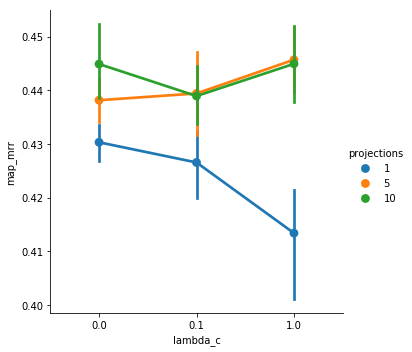

In [234]:
sns.catplot(x="lambda_c", y="map_mrr", hue="projections", kind="point", data=ft_regul);

In [230]:
ft_regul_model = ols('map_mrr ~ C(projections)+C(lambda_c)', ft_regul).fit()

# Seeing if the overall model is significant
print_model(ft_regul_model)

Overall model F( 4, 40) =  19.584, p =  0.0000000054


In [231]:
res = sm.stats.anova_lm(ft_regul_model, typ= 1)
anova_table(res)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(projections),0.006349,0.003174,2.0,36.043735,1.122170e-09,0.609169,0.587305
C(lambda_c),0.000550,0.000275,2.0,3.125001,5.482322e-02,0.052815,0.035613
Residual,0.003523,0.000088,40.0,NaN,NaN,NaN,NaN


# Between subjects effect; projections = 1

In [222]:
ft_regul_1 = ft_regul.loc[ft_regul.projections==1,]
ft_regul_model = ols('map_mrr ~ C(lambda_c)', ft_regul_1).fit()
print_model(ft_regul_model)

Overall model F( 2, 12) =  4.290, p =  0.0393105076


In [171]:
ft_regul_model.summary()

/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     4.290
Date:                Tue, 19 Mar 2019   Prob (F-statistic):             0.0393
Time:                        11:36:30   Log-Likelihood:                 50.092
No. Observations:                  15   AIC:                            -94.18
Df Residuals:                      12   BIC:                            -92.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4303      0.004    100.311      0.000       0.421       0.440
C(lambda_c)[T.0.1]    -0.0038      0.006     -0.620      0.547      -0.017       0.009
C(lambda_c)[T.1.0]    -0.0169      0.006     -2.789      0.016      -0.030      -0.004
==============================================================================
Omnibus:                        9.955   Durbin-Watson:                   0.739
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                6.162
Skew:                          -1.369   Prob(JB):                       0.0459
Kurtosis:                       4.537   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
res = sm.stats.anova_lm(ft_regul_model, typ= 1)
anova_table(res)


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(lambda_c),0.000789,0.000395,2.0,4.289631,0.039311,0.416889,0.304888
Residual,0.001104,0.000092,12.0,NaN,NaN,NaN,NaN


In [224]:
mc = statsmodels.stats.multicomp.MultiComparison(ft_regul_1['map_mrr'], ft_regul_1['lambda_c'])
mc_results = mc.tukeyhsd()
print(mc_results)

# regularisation @strength 1, when mixed with a single projection on fastText, damages map_mrr 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.1   -0.0038  -0.0199  0.0124 False 
 0.0    1.0   -0.0169  -0.0331 -0.0007  True 
 0.1    1.0   -0.0132  -0.0293  0.003  False 
---------------------------------------------


# Between subjects effect; projections = 5

In [174]:
ft_regul_5 = ft_regul.loc[ft_regul.projections==5,]
ft_regul_model = ols('map_mrr ~ C(lambda_c)', ft_regul_5).fit()
print_model(ft_regul_model)

# no effect, when projections = 5

Overall model F( 2, 12) =  1.274, p =  0.3150593920


# Between subjects effect, projections = 10

In [175]:
ft_regul_10 = ft_regul.loc[ft_regul.projections==10,]
ft_regul_model = ols('map_mrr ~ C(lambda_c)', ft_regul_10).fit()
print_model(ft_regul_model)

# no effect, when projections = 10

Overall model F( 2, 12) =  0.859, p =  0.4480548711
